In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve, validation_curve

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

In [3]:
# Load the dataset
df = pd.read_csv('sleep_efficiency.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (452, 15)

Column Names and Data Types:
ID                          int64
Age                         int64
Gender                     object
Bedtime                    object
Wakeup time                object
Sleep duration            float64
Sleep efficiency          float64
REM sleep percentage        int64
Deep sleep percentage       int64
Light sleep percentage      int64
Awakenings                float64
Caffeine consumption      float64
Alcohol consumption       float64
Smoking status             object
Exercise frequency        float64
dtype: object

First 5 rows:
   ID  Age  Gender              Bedtime          Wakeup time  Sleep duration  \
0   1   65  Female  2021-03-06 01:00:00  2021-03-06 07:00:00             6.0   
1   2   69    Male  2021-12-05 02:00:00  2021-12-05 09:00:00             7.0   
2   3   40  Female  2021-05-25 21:30:00  2021-05-25 05:30:00             8.0   
3   4   40  Female  2021-11-03 02:30:00  2021-11-03 08:30:00             6.0   
4   5 

In [4]:
# Create a copy of the dataset for preprocessing
df_processed = df.copy()

# Handle missing values in 'Caffeine consumption' if any (replace with median)
if df_processed['Caffeine consumption'].isnull().sum() > 0:
    df_processed['Caffeine consumption'].fillna(df_processed['Caffeine consumption'].median(), inplace=True)

# Convert datetime columns to extract useful features
def parse_time(time_str):
    """Parse time string and convert to hours"""
    try:
        # Handle different date formats
        if '/' in time_str:
            dt = pd.to_datetime(time_str, format='%d/%m/%y %H:%M')
        else:
            dt = pd.to_datetime(time_str, format='%d-%m-%y %H:%M')
        return dt.hour + dt.minute/60
    except:
        return np.nan

# Extract bedtime and wakeup time as numerical features
df_processed['Bedtime_hour'] = df_processed['Bedtime'].apply(parse_time)
df_processed['Wakeup_hour'] = df_processed['Wakeup time'].apply(parse_time)

# Create additional features
df_processed['Sleep_schedule_consistency'] = abs(df_processed['Bedtime_hour'] - 22)  # Distance from 10 PM
df_processed['Weekend_sleep_in'] = df_processed['Wakeup_hour'] > 8  # Late wakeup indicator

# Encode categorical variables
le_gender = LabelEncoder()
df_processed['Gender_encoded'] = le_gender.fit_transform(df_processed['Gender'])

le_smoking = LabelEncoder()
df_processed['Smoking_encoded'] = le_smoking.fit_transform(df_processed['Smoking status'])

# Create target variable based on sleep patterns and efficiency
# This is a synthetic target since the original dataset doesn't have sleep disorders
# We'll create it based on sleep efficiency and other factors
def classify_sleep_disorder(row):
    """Create sleep disorder classification based on sleep metrics"""
    efficiency = row['Sleep efficiency']
    awakenings = row['Awakenings']
    rem_sleep = row['REM sleep percentage']
    deep_sleep = row['Deep sleep percentage']

    # Sleep Apnea indicators: Low efficiency, high awakenings, low deep sleep
    if efficiency < 0.6 and awakenings >= 3 and deep_sleep < 30:
        return 'Sleep Apnea'
    # Insomnia indicators: Low efficiency, high awakenings, low sleep duration
    elif efficiency < 0.7 and awakenings >= 2:
        return 'Insomnia'
    else:
        return 'None'

df_processed['Sleep_Disorder'] = df_processed.apply(classify_sleep_disorder, axis=1)

# Select features for modeling
feature_columns = [
    'Age', 'Gender_encoded', 'Sleep duration', 'Sleep efficiency',
    'REM sleep percentage', 'Deep sleep percentage', 'Light sleep percentage',
    'Awakenings', 'Caffeine consumption', 'Alcohol consumption',
    'Smoking_encoded', 'Exercise frequency', 'Bedtime_hour', 'Wakeup_hour',
    'Sleep_schedule_consistency'
]

X = df_processed[feature_columns]
y = df_processed['Sleep_Disorder']

# Handle any remaining missing values
X = X.fillna(X.median())

print("Preprocessed dataset shape:", X.shape)
print("Target distribution:")
print(y.value_counts())
print("\nFeature columns:")
print(feature_columns)

Preprocessed dataset shape: (452, 15)
Target distribution:
Sleep_Disorder
None           375
Insomnia        60
Sleep Apnea     17
Name: count, dtype: int64

Feature columns:
['Age', 'Gender_encoded', 'Sleep duration', 'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage', 'Light sleep percentage', 'Awakenings', 'Caffeine consumption', 'Alcohol consumption', 'Smoking_encoded', 'Exercise frequency', 'Bedtime_hour', 'Wakeup_hour', 'Sleep_schedule_consistency']


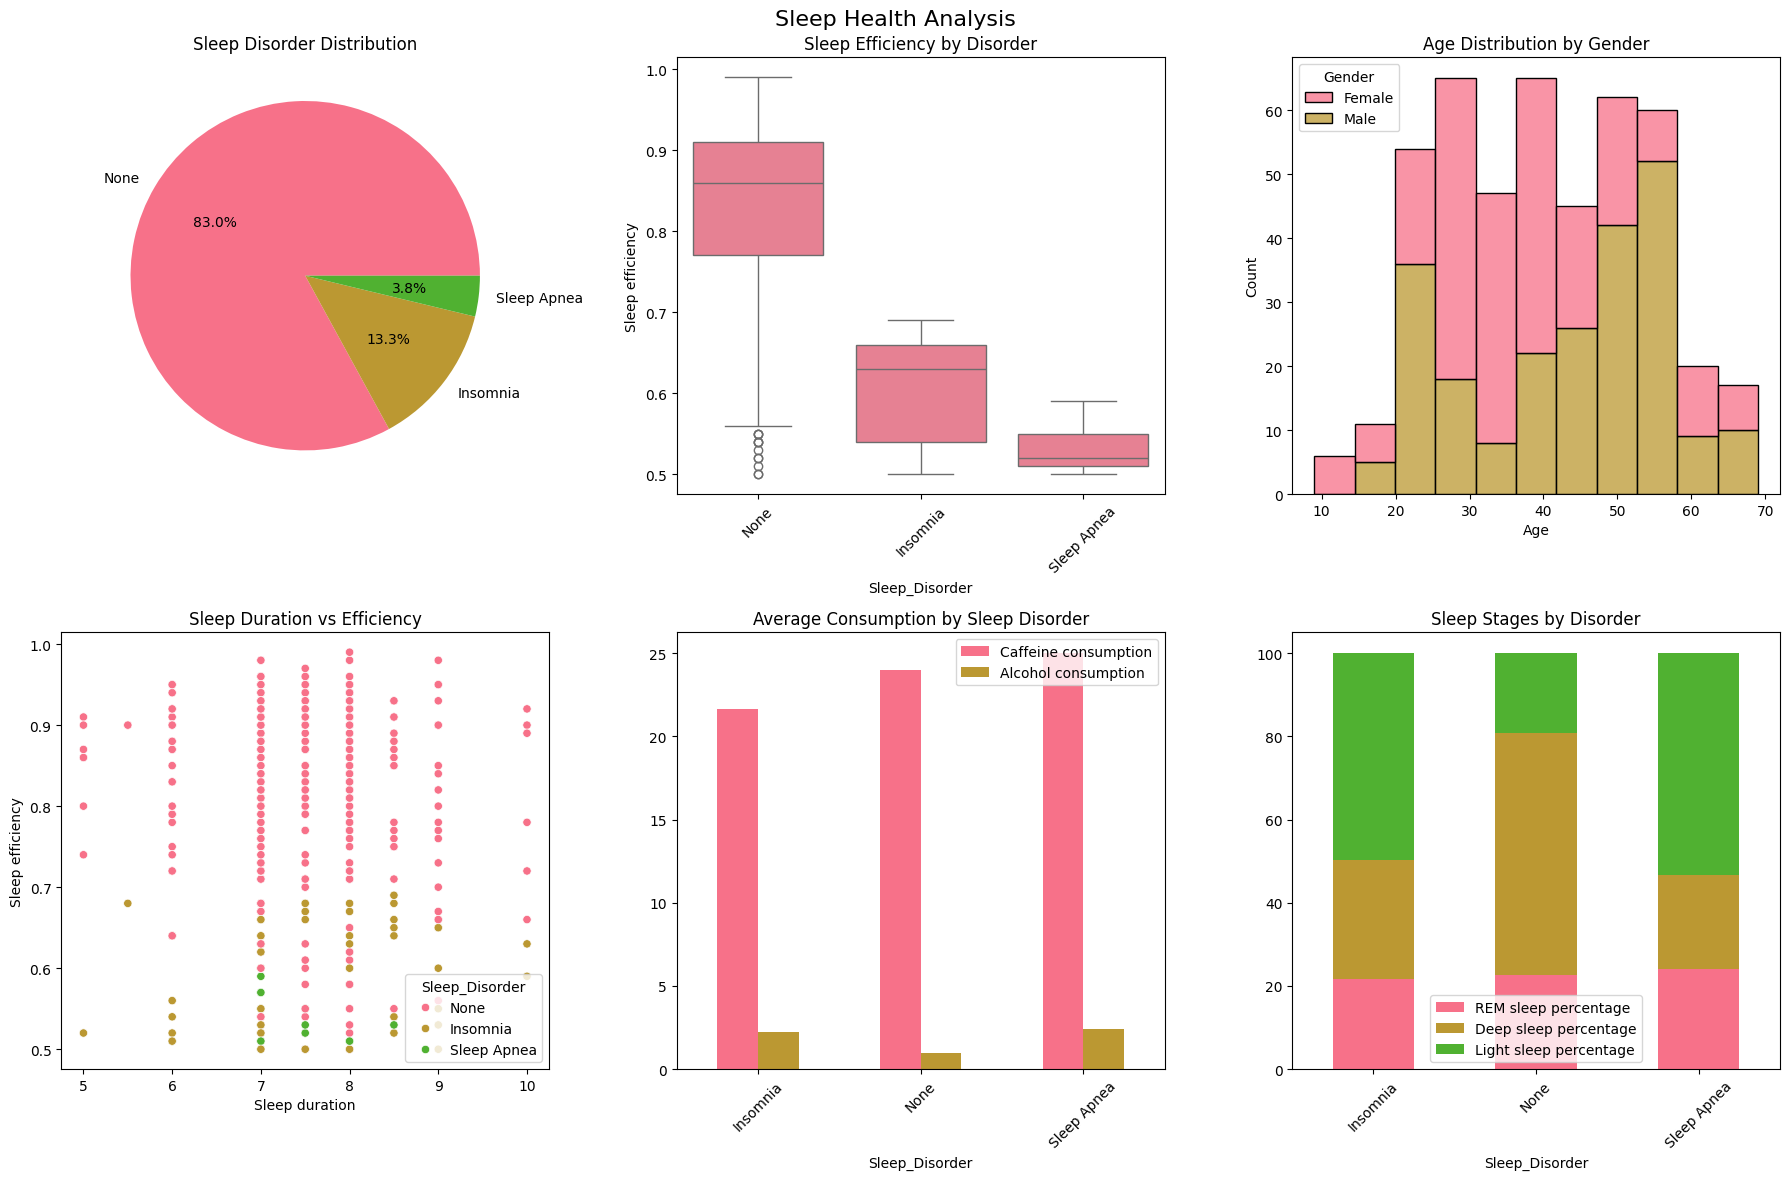

In [58]:
# Create visualizations for EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sleep Health Analysis', fontsize=16)

# 1. Sleep Disorder Distribution
axes[0, 0].pie(y.value_counts().values, labels=y.value_counts().index, autopct='%1.1f%%')
axes[0, 0].set_title('Sleep Disorder Distribution')

# 2. Sleep Efficiency by Disorder
sns.boxplot(data=df_processed, x='Sleep_Disorder', y='Sleep efficiency', ax=axes[0, 1])
axes[0, 1].set_title('Sleep Efficiency by Disorder')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Age Distribution by Gender
sns.histplot(data=df_processed, x='Age', hue='Gender', multiple='stack', ax=axes[0, 2])
axes[0, 2].set_title('Age Distribution by Gender')

# 4. Sleep Duration vs Efficiency
sns.scatterplot(data=df_processed, x='Sleep duration', y='Sleep efficiency',
                hue='Sleep_Disorder', ax=axes[1, 0])
axes[1, 0].set_title('Sleep Duration vs Efficiency')

# 5. Caffeine and Alcohol Consumption
df_consumption = df_processed.groupby('Sleep_Disorder')[['Caffeine consumption', 'Alcohol consumption']].mean()
df_consumption.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Average Consumption by Sleep Disorder')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Sleep Stages by Disorder
sleep_stages = df_processed.groupby('Sleep_Disorder')[['REM sleep percentage', 'Deep sleep percentage', 'Light sleep percentage']].mean()
sleep_stages.plot(kind='bar', stacked=True, ax=axes[1, 2])
axes[1, 2].set_title('Sleep Stages by Disorder')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


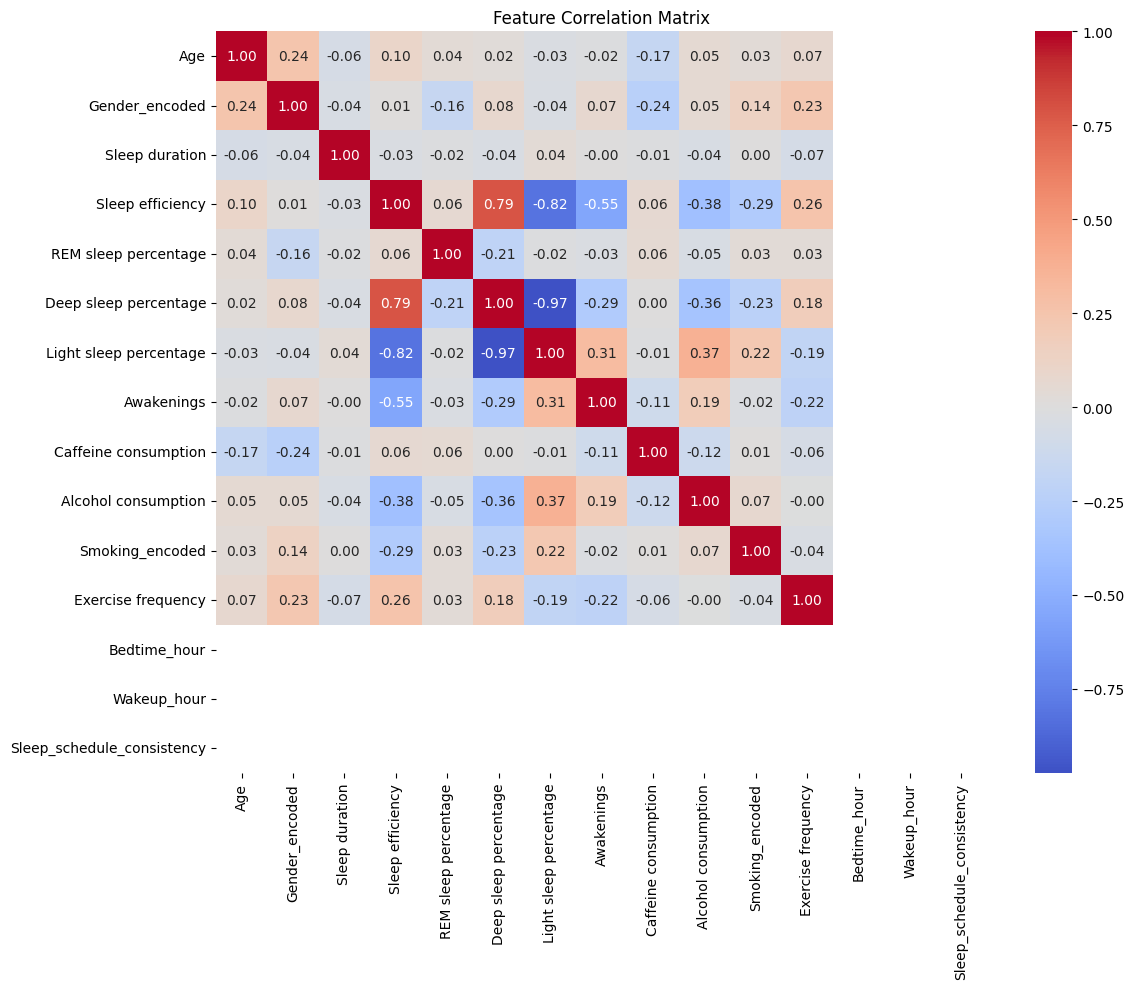

In [59]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\nTraining set target distribution:")
print(y_train.value_counts())
print("\nTest set target distribution:")
print(y_test.value_counts())

Training set shape: (361, 15)
Test set shape: (91, 15)

Training set target distribution:
Sleep_Disorder
None           299
Insomnia        48
Sleep Apnea     14
Name: count, dtype: int64

Test set target distribution:
Sleep_Disorder
None           76
Insomnia       12
Sleep Apnea     3
Name: count, dtype: int64


In [9]:
# Impute missing values first, then scale
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can choose 'median' or others
    ('scaler', StandardScaler())
])

# Fit transform the train set, transform the test set
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [11]:
# Train and evaluate each model
model_results = {}
trained_models = {}

print("Training and evaluating models...")

for name, model in models.items():
    print(f"\nTraining {name}...")

    try:
        model.fit(X_train_preprocessed, y_train)
        trained_models[name] = model

        y_pred = model.predict(X_test_preprocessed)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        cv_scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        model_results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV Mean': cv_mean,
            'CV Std': cv_std,
            'Predictions': y_pred
        }

        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"CV Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")

    except ValueError as e:
        print(f"Error training {name}: {e}")


Training and evaluating models...

Training Random Forest...
Accuracy: 0.9890
F1-Score: 0.9896
CV Score: 0.9779 (+/- 0.0135)

Training Decision Tree...
Accuracy: 1.0000
F1-Score: 1.0000
CV Score: 0.9889 (+/- 0.0111)

Training SVM...
Accuracy: 0.9560
F1-Score: 0.9542
CV Score: 0.9365 (+/- 0.0610)

Training Logistic Regression...
Accuracy: 0.9780
F1-Score: 0.9734
CV Score: 0.9392 (+/- 0.0681)

Training K-Nearest Neighbors...
Accuracy: 0.9560
F1-Score: 0.9545
CV Score: 0.9089 (+/- 0.1057)

Training Gradient Boosting...
Accuracy: 1.0000
F1-Score: 1.0000
CV Score: 0.9917 (+/- 0.0135)

Training Neural Network...
Accuracy: 0.9670
F1-Score: 0.9664
CV Score: 0.9503 (+/- 0.0705)


Model Comparison Results:
                     Accuracy Precision    Recall  F1-Score   CV Mean  \
Random Forest        0.989011  0.991758  0.989011  0.989557  0.977854   
Decision Tree             1.0       1.0       1.0       1.0  0.988927   
SVM                  0.956044   0.95441  0.956044  0.954189  0.936454   
Logistic Regression  0.978022  0.981162  0.978022  0.973373  0.939231   
K-Nearest Neighbors  0.956044   0.95589  0.956044  0.954514  0.908866   
Gradient Boosting         1.0       1.0       1.0       1.0  0.991705   
Neural Network       0.967033  0.966177  0.967033  0.966352  0.950304   

                       CV Std  
Random Forest        0.006743  
Decision Tree        0.005537  
SVM                   0.03051  
Logistic Regression  0.034065  
K-Nearest Neighbors  0.052848  
Gradient Boosting    0.006773  
Neural Network       0.035271  

Best Model: Decision Tree
Best F1-Score: 1.0000


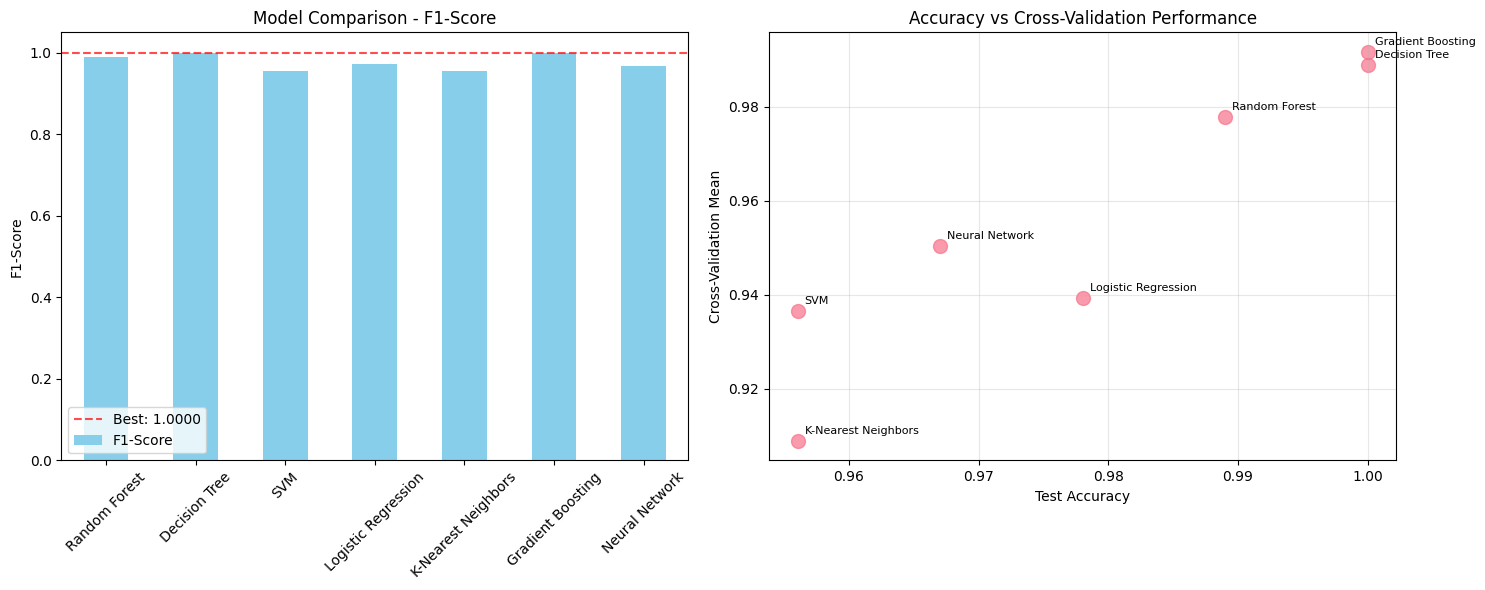

In [12]:
# Create comparison DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Mean', 'CV Std']]

print("Model Comparison Results:")
print(results_df.round(4))

# Find the best model based on F1-score
best_model_name = results_df['F1-Score'].idxmax()
best_model = trained_models[best_model_name]
best_f1_score = results_df.loc[best_model_name, 'F1-Score']

print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score: {best_f1_score:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of F1-scores
results_df['F1-Score'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Model Comparison - F1-Score')
axes[0].set_ylabel('F1-Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=best_f1_score, color='red', linestyle='--', alpha=0.7, label=f'Best: {best_f1_score:.4f}')
axes[0].legend()

# Accuracy vs CV Score scatter plot
axes[1].scatter(results_df['Accuracy'], results_df['CV Mean'], s=100, alpha=0.7)
for i, model in enumerate(results_df.index):
    axes[1].annotate(model, (results_df.iloc[i]['Accuracy'], results_df.iloc[i]['CV Mean']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1].set_xlabel('Test Accuracy')
axes[1].set_ylabel('Cross-Validation Mean')
axes[1].set_title('Accuracy vs Cross-Validation Performance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

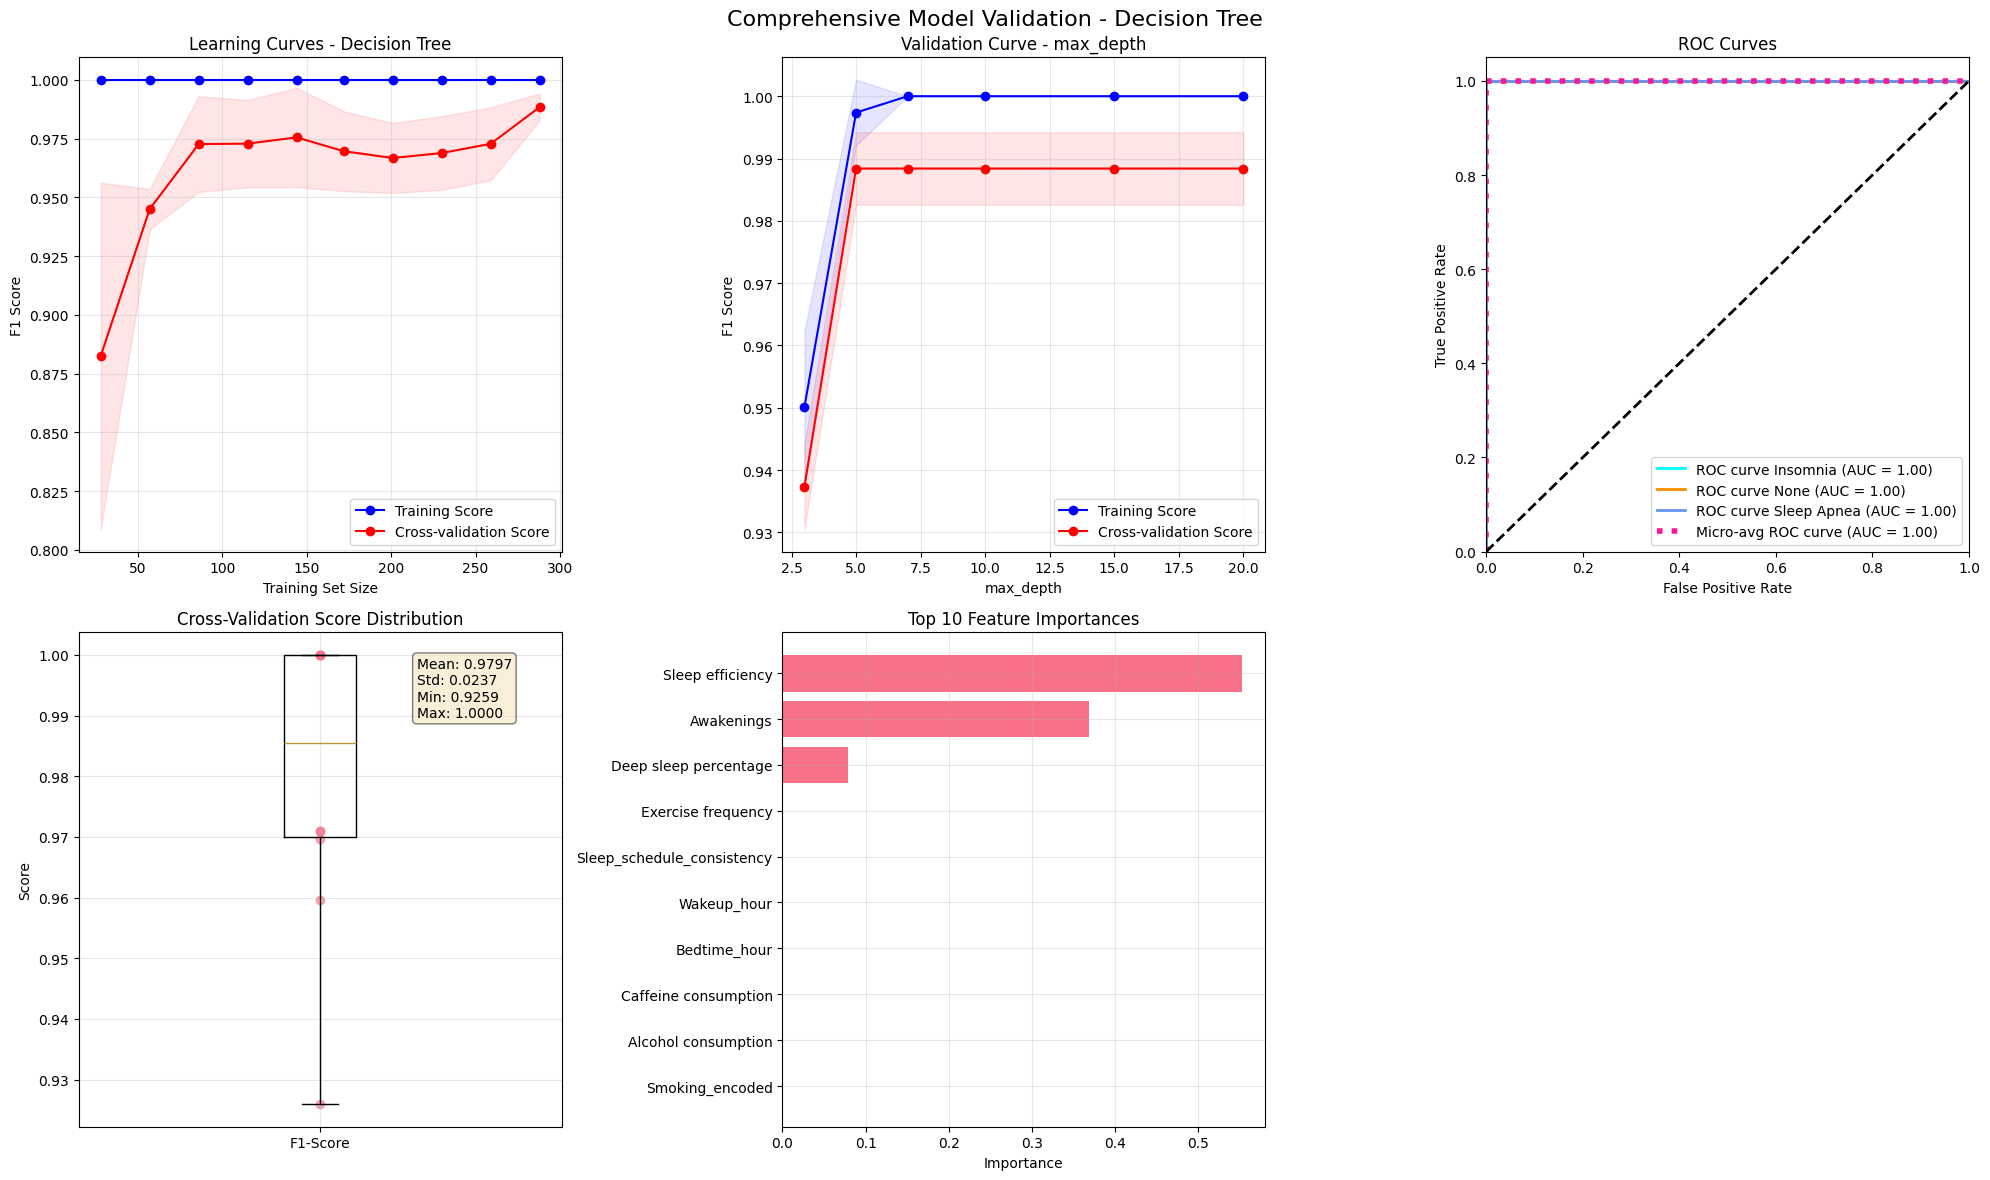

In [48]:
# Comprehensive Validation Visualization
def plot_validation_results(validation_results, model_name):
    """
    Create comprehensive validation plots
    """

    fig = plt.figure(figsize=(20, 12))

    # 1. Learning Curves
    plt.subplot(2, 3, 1)
    train_sizes, train_scores, val_scores = validation_results['learning_curve']

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Cross-validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {model_name}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # 2. Validation Curves
    plt.subplot(2, 3, 2)
    if validation_results['validation_curve'] is not None:
        train_scores_val, test_scores_val = validation_results['validation_curve']
        param_name, param_range = get_validation_param(model_name)

        train_mean = np.mean(train_scores_val, axis=1)
        train_std = np.std(train_scores_val, axis=1)
        test_mean = np.mean(test_scores_val, axis=1)
        test_std = np.std(test_scores_val, axis=1)

        plt.plot(param_range, train_mean, 'o-', color='blue', label='Training Score')
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

        plt.plot(param_range, test_mean, 'o-', color='red', label='Cross-validation Score')
        plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')

        plt.xlabel(param_name)
        plt.ylabel('F1 Score')
        plt.title(f'Validation Curve - {param_name}')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Validation Curve\nNot Available', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=12)
        plt.title('Validation Curve')

    # 3. ROC Curves
    plt.subplot(2, 3, 3)
    if validation_results['roc_data'] is not None:
        fpr, tpr, roc_auc = validation_results['roc_data']

        # Plot ROC curve for each class
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(len(final_model.classes_)), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'ROC curve {final_model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

        # Plot micro-average ROC curve
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'Micro-avg ROC curve (AUC = {roc_auc["micro"]:.2f})',
                color='deeppink', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
    else:
        plt.text(0.5, 0.5, 'ROC Curves\nNot Available', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=12)
        plt.title('ROC Curves')

    # 4. Cross-Validation Score Distribution
    plt.subplot(2, 3, 4)
    cv_scores = validation_results['cv_results']['test_f1_weighted']
    plt.boxplot([cv_scores], labels=['F1-Score'])
    plt.scatter([1] * len(cv_scores), cv_scores, alpha=0.6)
    plt.ylabel('Score')
    plt.title('Cross-Validation Score Distribution')
    plt.grid(True, alpha=0.3)

    # Add statistics
    plt.text(0.7, 0.95, f'Mean: {cv_scores.mean():.4f}\nStd: {cv_scores.std():.4f}\nMin: {cv_scores.min():.4f}\nMax: {cv_scores.max():.4f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 5. Feature Importance with Error Bars (for ensemble methods)
    plt.subplot(2, 3, 5)
    if hasattr(final_model, 'feature_importances_'):
        # For models with feature importance, show top features
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': final_model.feature_importances_
        }).sort_values('importance', ascending=True).tail(10)

        plt.barh(range(len(feature_importance)), feature_importance['importance'])
        plt.yticks(range(len(feature_importance)), feature_importance['feature'])
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importances')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Feature Importance\nNot Available', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=12)
        plt.title('Feature Importance')

    plt.suptitle(f'Comprehensive Model Validation - {model_name}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Generate validation visualizations
plot_validation_results(validation_results, best_model_name)

Detailed Analysis of Decision Tree

Classification Report:
              precision    recall  f1-score   support

    Insomnia       1.00      1.00      1.00        12
        None       1.00      1.00      1.00        76
 Sleep Apnea       1.00      1.00      1.00         3

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



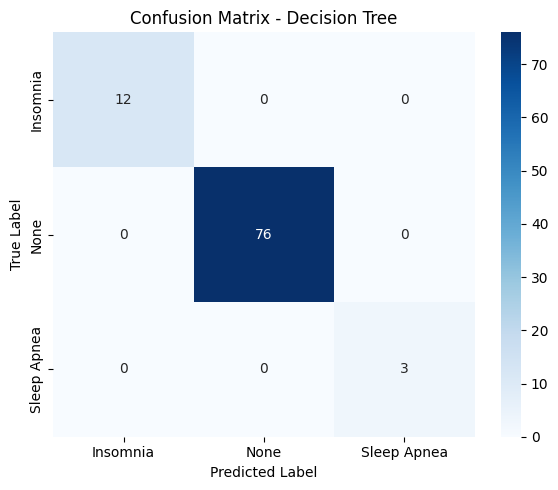

In [25]:
# Analysis of the best model
best_predictions = model_results[best_model_name]['Predictions']

print(f"Detailed Analysis of {best_model_name}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()


In [50]:
print(f"Performing hyperparameter tuning for {best_model_name}...")

# Save original model metrics before tuning
original_accuracy = model_results[best_model_name]['Accuracy']
original_f1 = model_results[best_model_name]['F1-Score']

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'lbfgs']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

if best_model_name in param_grids:
    param_grid = param_grids[best_model_name]

    if best_model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42)
    elif best_model_name == 'Decision Tree':
        base_model = DecisionTreeClassifier(random_state=42)
    elif best_model_name == 'SVM':
        base_model = SVC(random_state=42)
    elif best_model_name == 'Logistic Regression':
        base_model = LogisticRegression(random_state=42, max_iter=1000)
    elif best_model_name == 'K-Nearest Neighbors':
        base_model = KNeighborsClassifier()
    elif best_model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif best_model_name == 'Neural Network':
        base_model = MLPClassifier(max_iter=1000, random_state=42)

    grid_search = GridSearchCV(
        base_model, param_grid, cv=5, scoring='f1_weighted',
        n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_tuned_model = grid_search.best_estimator_

    y_pred_tuned = best_tuned_model.predict(X_test_scaled)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    tuned_f1 = f1_score(y_test, y_pred_tuned, average='weighted')

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print(f"Tuned model test accuracy: {tuned_accuracy:.4f}")
    print(f"Tuned model test F1-score: {tuned_f1:.4f}")

    final_model = best_tuned_model
else:
    print(f"No parameter grid defined for {best_model_name}")
    final_model = best_model


Performing hyperparameter tuning for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.9884
Tuned model test accuracy: 1.0000
Tuned model test F1-score: 1.0000


# Interactive User Testing Interface

Current total: 115%
Adjusting proportionally...
 SLEEP DISORDER PREDICTION RESULTS
 PREDICTION: No Sleep Disorder Detected

 CONFIDENCE LEVELS:
   None        : 100.0% 20
   Insomnia    :   0.0% 0
   Sleep Apnea :   0.0% 0

 RISK FACTOR ANALYSIS:
   🟢 Protective Factors:
      • Few awakenings (1)
      • Good deep sleep (52%)
      • Moderate caffeine intake (45mg)
      • Low alcohol consumption (0 drinks)
      • Non-smoker
      • Good exercise frequency (4 days/week)

 PERSONALIZED RECOMMENDATIONS:
   1. Maintain your current healthy sleep habits!


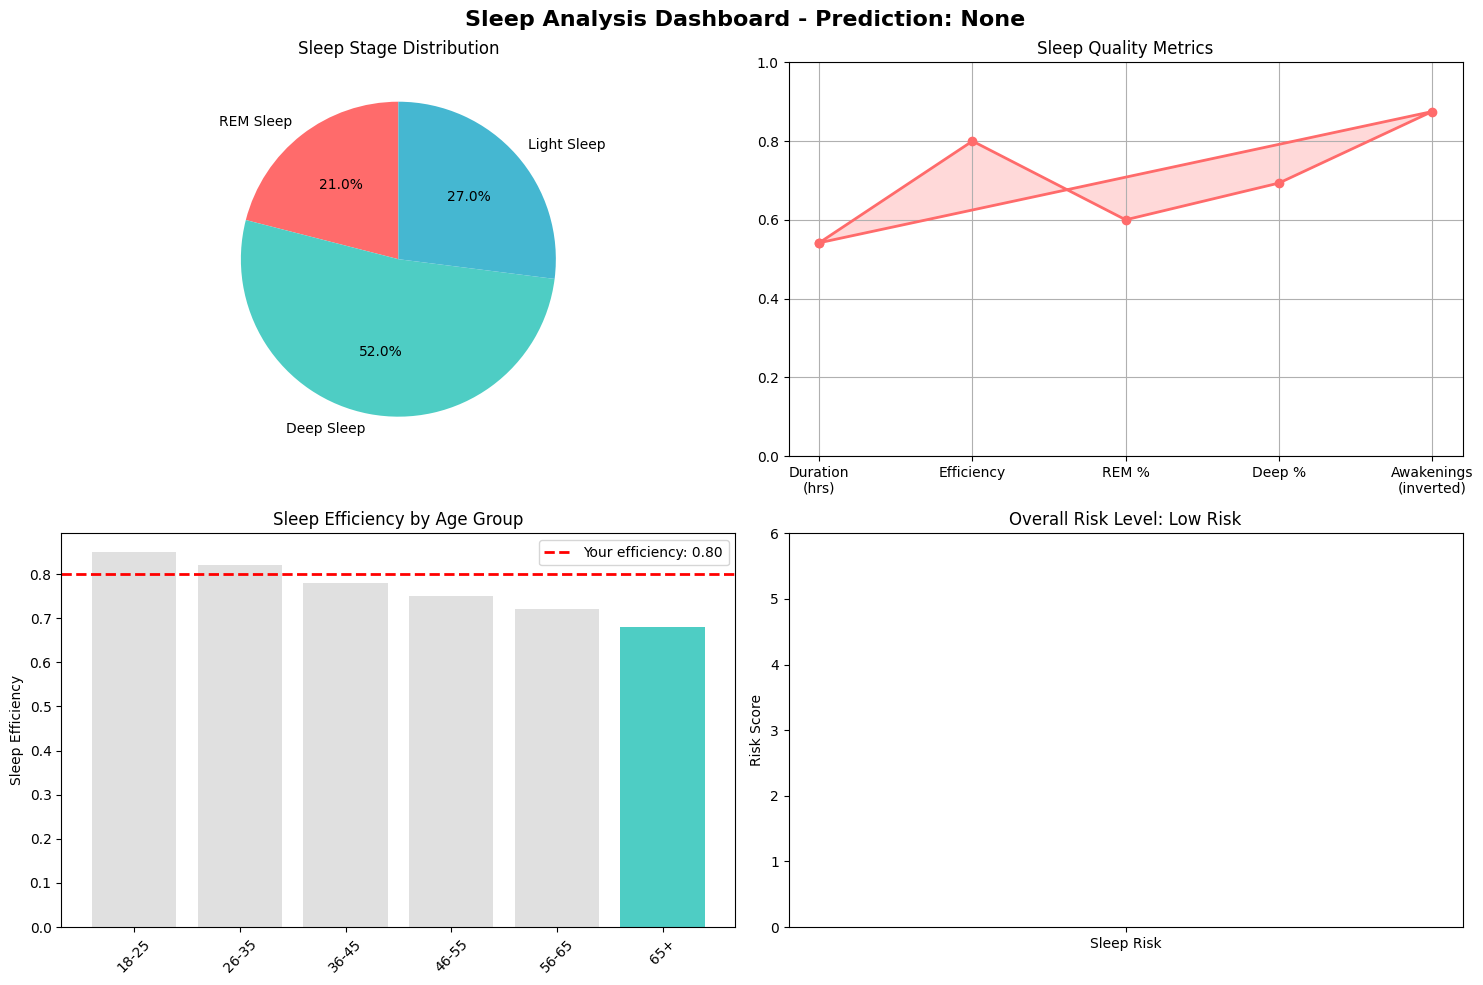

In [57]:
def create_interactive_interface():

    # Create input widgets
    print("Creating Interactive Sleep Disorder Prediction Interface...")

    # Personal Information
    age_slider = widgets.IntSlider(
        value=30, min=10, max=80, step=1,
        description='Age:', style={'description_width': 'initial'}
    )

    gender_dropdown = widgets.Dropdown(
        options=['Female', 'Male'],
        value='Female',
        description='Gender:', style={'description_width': 'initial'}
    )

    # Sleep Metrics
    sleep_duration_slider = widgets.FloatSlider(
        value=8.0, min=4.0, max=12.0, step=0.5,
        description='Sleep Duration (hrs):', style={'description_width': 'initial'}
    )

    sleep_efficiency_slider = widgets.FloatSlider(
        value=0.85, min=0.3, max=1.0, step=0.01,
        description='Sleep Efficiency:', style={'description_width': 'initial'}
    )

    rem_sleep_slider = widgets.IntSlider(
        value=22, min=10, max=35, step=1,
        description='REM Sleep %:', style={'description_width': 'initial'}
    )

    deep_sleep_slider = widgets.IntSlider(
        value=50, min=15, max=75, step=1,
        description='Deep Sleep %:', style={'description_width': 'initial'}
    )

    light_sleep_slider = widgets.IntSlider(
        value=28, min=10, max=70, step=1,
        description='Light Sleep %:', style={'description_width': 'initial'}
    )

    awakenings_slider = widgets.IntSlider(
        value=1, min=0, max=8, step=1,
        description='Awakenings:', style={'description_width': 'initial'}
    )

    # Lifestyle Factors
    caffeine_slider = widgets.IntSlider(
        value=25, min=0, max=200, step=5,
        description='Caffeine (mg):', style={'description_width': 'initial'}
    )

    alcohol_slider = widgets.IntSlider(
        value=1, min=0, max=10, step=1,
        description='Alcohol (drinks):', style={'description_width': 'initial'}
    )

    smoking_dropdown = widgets.Dropdown(
        options=['No', 'Yes'],
        value='No',
        description='Smoking:', style={'description_width': 'initial'}
    )

    exercise_slider = widgets.IntSlider(
        value=3, min=0, max=7, step=1,
        description='Exercise (days/week):', style={'description_width': 'initial'}
    )

    # Sleep Schedule
    bedtime_slider = widgets.FloatSlider(
        value=22.0, min=18.0, max=26.0, step=0.5,
        description='Bedtime (24hr):', style={'description_width': 'initial'}
    )

    wakeup_slider = widgets.FloatSlider(
        value=6.0, min=4.0, max=12.0, step=0.5,
        description='Wake-up (24hr):', style={'description_width': 'initial'}
    )

    # Prediction button
    predict_button = widgets.Button(
        description='Predict Sleep Disorder',
        button_style='primary',
        layout=widgets.Layout(width='200px', height='40px')
    )

    # Output area
    output = widgets.Output()

    def on_predict_click(b):
        with output:
            clear_output()
            make_prediction_with_analysis()

    def make_prediction_with_analysis():
        """Make prediction and display comprehensive analysis"""

        # Get current values
        age = age_slider.value
        gender = gender_dropdown.value
        sleep_duration = sleep_duration_slider.value
        sleep_efficiency = sleep_efficiency_slider.value
        rem_sleep = rem_sleep_slider.value
        deep_sleep = deep_sleep_slider.value
        light_sleep = light_sleep_slider.value
        awakenings = awakenings_slider.value
        caffeine = caffeine_slider.value
        alcohol = alcohol_slider.value
        smoking = smoking_dropdown.value
        exercise = exercise_slider.value
        bedtime_hour = bedtime_slider.value
        wakeup_hour = wakeup_slider.value

        # Validate sleep percentages
        total_sleep_percentage = rem_sleep + deep_sleep + light_sleep
        if abs(total_sleep_percentage - 100) > 5:
            print(" Warning: Sleep percentages should add up to ~100%")
            print(f"Current total: {total_sleep_percentage}%")
            print("Adjusting proportionally...")
            # Normalize percentages
            rem_sleep = int(rem_sleep * 100 / total_sleep_percentage)
            deep_sleep = int(deep_sleep * 100 / total_sleep_percentage)
            light_sleep = 100 - rem_sleep - deep_sleep

        # Make prediction
        prediction, probabilities = predict_sleep_disorder(
            final_model, scaler, age, gender, sleep_duration, sleep_efficiency,
            rem_sleep, deep_sleep, light_sleep, awakenings, caffeine,
            alcohol, smoking, exercise, bedtime_hour, wakeup_hour
        )

        # Display results with styling
        print(" SLEEP DISORDER PREDICTION RESULTS")
        print("=" * 50)

        # Main prediction
        if prediction == 'None':
            print(" PREDICTION: No Sleep Disorder Detected")
            risk_color = 'green'
        elif prediction == 'Insomnia':
            print("  PREDICTION: Insomnia Risk Detected")
            risk_color = 'orange'
        else:
            print(" PREDICTION: Sleep Apnea Risk Detected")
            risk_color = 'red'

        # Probability breakdown
        if probabilities is not None:
            print("\n CONFIDENCE LEVELS:")
            prob_dict = dict(zip(final_model.classes_, probabilities))
            for disorder, prob in sorted(prob_dict.items(), key=lambda x: x[1], reverse=True):
                percentage = prob * 100
                bar = int(percentage / 5)
                print(f"   {disorder:12}: {percentage:5.1f}% {bar}")

        # Risk factors analysis
        print("\n RISK FACTOR ANALYSIS:")
        risk_factors = []
        protective_factors = []

        # Analyze each factor
        if sleep_efficiency < 0.7:
            risk_factors.append(f"Low sleep efficiency ({sleep_efficiency:.2f})")
        elif sleep_efficiency > 0.85:
            protective_factors.append(f"Good sleep efficiency ({sleep_efficiency:.2f})")

        if awakenings >= 3:
            risk_factors.append(f"Frequent awakenings ({awakenings})")
        elif awakenings <= 1:
            protective_factors.append(f"Few awakenings ({awakenings})")

        if deep_sleep < 30:
            risk_factors.append(f"Low deep sleep ({deep_sleep}%)")
        elif deep_sleep > 50:
            protective_factors.append(f"Good deep sleep ({deep_sleep}%)")

        if caffeine > 100:
            risk_factors.append(f"High caffeine intake ({caffeine}mg)")
        elif caffeine < 50:
            protective_factors.append(f"Moderate caffeine intake ({caffeine}mg)")

        if alcohol > 3:
            risk_factors.append(f"High alcohol consumption ({alcohol} drinks)")
        elif alcohol <= 1:
            protective_factors.append(f"Low alcohol consumption ({alcohol} drinks)")

        if smoking == 'Yes':
            risk_factors.append("Smoking habit")
        else:
            protective_factors.append("Non-smoker")

        if exercise < 2:
            risk_factors.append(f"Low exercise frequency ({exercise} days/week)")
        elif exercise >= 4:
            protective_factors.append(f"Good exercise frequency ({exercise} days/week)")

        # Display risk factors
        if risk_factors:
            print("   🔴 Risk Factors:")
            for factor in risk_factors:
                print(f"      • {factor}")

        if protective_factors:
            print("   🟢 Protective Factors:")
            for factor in protective_factors:
                print(f"      • {factor}")

        # Recommendations
        print("\n PERSONALIZED RECOMMENDATIONS:")
        recommendations = []

        if sleep_efficiency < 0.8:
            recommendations.append("Improve sleep hygiene and bedroom environment")
        if awakenings >= 2:
            recommendations.append("Consider relaxation techniques before bed")
        if deep_sleep < 40:
            recommendations.append("Maintain regular sleep schedule and avoid screens before bed")
        if caffeine > 50:
            recommendations.append("Reduce caffeine intake, especially after 2 PM")
        if alcohol > 2:
            recommendations.append("Limit alcohol consumption, especially before bedtime")
        if exercise < 3:
            recommendations.append("Increase regular physical activity")
        if abs(bedtime_hour - 22) > 2:
            recommendations.append("Try to maintain a consistent bedtime around 10 PM")

        if not recommendations:
            recommendations.append("Maintain your current healthy sleep habits!")

        for i, rec in enumerate(recommendations, 1):
            print(f"   {i}. {rec}")

        # Sleep quality visualization
        create_sleep_analysis_chart(age, sleep_duration, sleep_efficiency, rem_sleep,
                                  deep_sleep, light_sleep, awakenings, prediction)

    predict_button.on_click(on_predict_click)

    # Layout the interface
    personal_box = widgets.VBox([
        widgets.HTML("<h3>👤 Personal Information</h3>"),
        age_slider, gender_dropdown
    ])

    sleep_metrics_box = widgets.VBox([
        widgets.HTML("<h3>😴 Sleep Metrics</h3>"),
        sleep_duration_slider, sleep_efficiency_slider,
        rem_sleep_slider, deep_sleep_slider, light_sleep_slider, awakenings_slider
    ])

    lifestyle_box = widgets.VBox([
        widgets.HTML("<h3>🏃 Lifestyle Factors</h3>"),
        caffeine_slider, alcohol_slider, smoking_dropdown, exercise_slider
    ])

    schedule_box = widgets.VBox([
        widgets.HTML("<h3>⏰ Sleep Schedule</h3>"),
        bedtime_slider, wakeup_slider
    ])

    controls_box = widgets.HBox([personal_box, sleep_metrics_box, lifestyle_box, schedule_box])

    interface = widgets.VBox([
        widgets.HTML("<h2>Interactive Sleep Disorder Prediction Tool</h2>"),
        widgets.HTML("<p>Adjust the parameters below to analyze your sleep patterns and get personalized recommendations:</p>"),
        controls_box,
        widgets.HTML("<br>"),
        predict_button,
        output
    ])

    return interface

def create_sleep_analysis_chart(age, sleep_duration, sleep_efficiency, rem_sleep,
                               deep_sleep, light_sleep, awakenings, prediction):
    """Create visualization of sleep analysis"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Sleep Analysis Dashboard - Prediction: {prediction}', fontsize=16, fontweight='bold')

    # 1. Sleep stages pie chart
    stages = [rem_sleep, deep_sleep, light_sleep]
    labels = ['REM Sleep', 'Deep Sleep', 'Light Sleep']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    ax1.pie(stages, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Sleep Stage Distribution')

    # 2. Sleep metrics radar chart
    categories = ['Duration\n(hrs)', 'Efficiency', 'REM %', 'Deep %', 'Awakenings\n(inverted)']
    values = [
        sleep_duration / 12,  # Normalize to 0-1
        sleep_efficiency,
        rem_sleep / 35,
        deep_sleep / 75,
        1 - (awakenings / 8)  # Invert awakenings (fewer is better)
    ]

    # Create radar chart
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  # Complete the circle
    angles += angles[:1]

    ax2.plot(angles, values, 'o-', linewidth=2, color='#FF6B6B')
    ax2.fill(angles, values, alpha=0.25, color='#FF6B6B')
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0, 1)
    ax2.set_title('Sleep Quality Metrics')
    ax2.grid(True)

    # 3. Age comparison
    age_ranges = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    avg_efficiency = [0.85, 0.82, 0.78, 0.75, 0.72, 0.68]  # Typical values

    user_age_range = '65+' if age >= 65 else f"{(age//10)*10}-{(age//10)*10+9}"
    if user_age_range not in age_ranges:
        if age < 18:
            user_age_range = '18-25'
        else:
            user_age_range = '65+'

    colors_bar = ['#4ECDC4' if ar == user_age_range else '#E0E0E0' for ar in age_ranges]

    bars = ax3.bar(age_ranges, avg_efficiency, color=colors_bar)
    ax3.axhline(y=sleep_efficiency, color='red', linestyle='--', linewidth=2, label=f'Your efficiency: {sleep_efficiency:.2f}')
    ax3.set_title('Sleep Efficiency by Age Group')
    ax3.set_ylabel('Sleep Efficiency')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

    # 4. Risk factors summary
    risk_score = 0
    risk_factors = []

    if sleep_efficiency < 0.7:
        risk_score += 2
        risk_factors.append('Low Efficiency')
    if awakenings >= 3:
        risk_score += 2
        risk_factors.append('Frequent Awakenings')
    if deep_sleep < 30:
        risk_score += 1
        risk_factors.append('Low Deep Sleep')
    if rem_sleep < 15:
        risk_score += 1
        risk_factors.append('Low REM Sleep')

    risk_levels = ['Low Risk', 'Moderate Risk', 'High Risk']
    risk_colors = ['green', 'orange', 'red']
    risk_level = min(risk_score // 2, 2)

    ax4.bar(['Sleep Risk'], [risk_score], color=risk_colors[risk_level], alpha=0.7)
    ax4.set_title(f'Overall Risk Level: {risk_levels[risk_level]}')
    ax4.set_ylabel('Risk Score')
    ax4.set_ylim(0, 6)

    # Add risk factors as text
    if risk_factors:
        risk_text = "Risk Factors:\n" + "\n".join([f"• {rf}" for rf in risk_factors])
        ax4.text(0.5, 0.95, risk_text, transform=ax4.transAxes,
                verticalalignment='top', horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Create and display the interactive interface
try:
    interface = create_interactive_interface()
    display(interface)

    print("\n INTERFACE READY!")
    print("Use the sliders and dropdowns above to input your sleep data,")
    print("then click 'Predict Sleep Disorder' to get your analysis!")

except ImportError:
    print(" Note: ipywidgets not available in this environment.")
    print("For full interactive experience, install ipywidgets:")
    print("pip install ipywidgets")
    print("\nAlternatively, here's a simplified command-line version:")

    # Command-line version
    def command_line_interface():
        """Simplified command-line interface for testing"""
        print(" SLEEP DISORDER PREDICTION - COMMAND LINE VERSION")

        try:
            # Get user input
            print("\nPlease enter your sleep information:")
            age = int(input("Age (10-80): ") or "30")
            gender = input("Gender (Male/Female): ") or "Female"

            sleep_duration = float(input("Sleep duration in hours (4-12): ") or "8")
            sleep_efficiency = float(input("Sleep efficiency (0.3-1.0): ") or "0.85")

            rem_sleep = int(input("REM sleep percentage (10-35): ") or "22")
            deep_sleep = int(input("Deep sleep percentage (15-75): ") or "50")
            light_sleep = int(input("Light sleep percentage (10-70): ") or "28")

            awakenings = int(input("Number of awakenings (0-8): ") or "1")
            caffeine = int(input("Daily caffeine intake in mg (0-200): ") or "25")
            alcohol = int(input("Daily alcohol drinks (0-10): ") or "1")

            smoking = input("Do you smoke? (Yes/No): ") or "No"
            exercise = int(input("Exercise days per week (0-7): ") or "3")

            bedtime = float(input("Bedtime in 24hr format (18-26): ") or "22")
            wakeup = float(input("Wake-up time in 24hr format (4-12): ") or "6")

            # Make prediction
            prediction, probabilities = predict_sleep_disorder(
                final_model, scaler, age, gender, sleep_duration, sleep_efficiency,
                rem_sleep, deep_sleep, light_sleep, awakenings, caffeine,
                alcohol, smoking, exercise, bedtime, wakeup
            )

            # Display results
            print("PREDICTION RESULTS")
            print("="*50)
            print(f"Predicted Sleep Disorder: {prediction}")

            if probabilities is not None:
                print("\nConfidence Levels:")
                prob_dict = dict(zip(final_model.classes_, probabilities))
                for disorder, prob in prob_dict.items():
                    print(f"  {disorder}: {prob*100:.1f}%")

            # Simple recommendations
            print("\n QUICK RECOMMENDATIONS:")
            if sleep_efficiency < 0.8:
                print("  • Work on improving sleep efficiency")
            if awakenings >= 2:
                print("  • Try relaxation techniques before bed")
            if caffeine > 100:
                print("  • Consider reducing caffeine intake")
            if exercise < 3:
                print("  • Increase regular physical activity")

        except KeyboardInterrupt:
            print("\nTesting cancelled by user.")
        except Exception as e:
            print(f"Error in input: {e}")
            print("Please ensure all inputs are valid numbers.")

    # Offer command-line version
    response = input("\nWould you like to try the command-line version? (y/n): ")
    if response.lower().startswith('y'):
        command_line_interface()

In [36]:
# Final evaluation and prediction function
def predict_sleep_disorder(model, scaler, age, gender, sleep_duration, sleep_efficiency,
                          rem_sleep, deep_sleep, light_sleep, awakenings, caffeine,
                          alcohol, smoking, exercise, bedtime_hour, wakeup_hour):
    """
    Predict sleep disorder for new data
    """
    # Encode categorical variables
    gender_encoded = 1 if gender.lower() == 'male' else 0
    smoking_encoded = 1 if smoking.lower() == 'yes' else 0
    sleep_schedule_consistency = abs(bedtime_hour - 22)

    # Create feature array
    features = np.array([[
        age, gender_encoded, sleep_duration, sleep_efficiency,
        rem_sleep, deep_sleep, light_sleep, awakenings,
        caffeine, alcohol, smoking_encoded, exercise,
        bedtime_hour, wakeup_hour, sleep_schedule_consistency
    ]])

    # Scale features
    features_scaled = scaler.transform(features)

    # Make prediction
    prediction = model.predict(features_scaled)[0]
    prediction_proba = model.predict_proba(features_scaled)[0] if hasattr(model, 'predict_proba') else None

    return prediction, prediction_proba

# Final model evaluation
final_predictions = final_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions, average='weighted')

print("FINAL MODEL PERFORMANCE")
print(f"Model: {best_model_name}")
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Final Test F1-Score: {final_f1:.4f}")

print("\nFinal Classification Report:")
print(classification_report(y_test, final_predictions))

# Example predictions
print("\nExample Predictions:")

# Example 1: Healthy sleeper
example_1 = predict_sleep_disorder(
    final_model, scaler, age=30, gender='Female', sleep_duration=8,
    sleep_efficiency=0.90, rem_sleep=25, deep_sleep=60, light_sleep=15,
    awakenings=1, caffeine=25, alcohol=1, smoking='No',
    exercise=4, bedtime_hour=22, wakeup_hour=6
)
print("Example 1 - Healthy sleeper profile:")
print(f"Predicted disorder: {example_1[0]}")
if example_1[1] is not None:
    proba_dict = dict(zip(final_model.classes_, example_1[1]))
    print(f"Probabilities: {proba_dict}")

# Example 2: Poor sleep quality
example_2 = predict_sleep_disorder(
    final_model, scaler, age=45, gender='Male', sleep_duration=5,
    sleep_efficiency=0.55, rem_sleep=15, deep_sleep=25, light_sleep=60,
    awakenings=4, caffeine=100, alcohol=3, smoking='Yes',
    exercise=1, bedtime_hour=1, wakeup_hour=6
)
print("\nExample 2 - Poor sleep quality profile:")
print(f"Predicted disorder: {example_2[0]}")
if example_2[1] is not None:
    proba_dict = dict(zip(final_model.classes_, example_2[1]))
    print(f"Probabilities: {proba_dict}")

# Save model summary
model_summary = {
    'Best Model': best_model_name,
    'Final Accuracy': final_accuracy,
    'Final F1-Score': final_f1,
    'Features Used': feature_columns,
    'Target Classes': list(final_model.classes_)
}

print("\nMODEL SUMMARY")
for key, value in model_summary.items():
    if isinstance(value, list):
        print(f"{key}: {len(value)} features/classes")
    else:
        print(f"{key}: {value}")

FINAL MODEL PERFORMANCE
Model: Decision Tree
Final Test Accuracy: 1.0000
Final Test F1-Score: 1.0000

Final Classification Report:
              precision    recall  f1-score   support

    Insomnia       1.00      1.00      1.00        12
        None       1.00      1.00      1.00        76
 Sleep Apnea       1.00      1.00      1.00         3

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91


Example Predictions:
Example 1 - Healthy sleeper profile:
Predicted disorder: None
Probabilities: {'Insomnia': np.float64(0.0), 'None': np.float64(1.0), 'Sleep Apnea': np.float64(0.0)}

Example 2 - Poor sleep quality profile:
Predicted disorder: Sleep Apnea
Probabilities: {'Insomnia': np.float64(0.0), 'None': np.float64(0.0), 'Sleep Apnea': np.float64(1.0)}

MODEL SUMMARY
Best Model: Decision Tree
Final Accuracy: 1.0
Final F1-Score: 1.0
Features Used: 15 features/classes
Target Clas